In [3]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
import os
from PIL import Image
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define emotion labels and number of classes
emotions = ['angry', 'fear', 'happy', 'sad', 'surprise']
num_classes = len(emotions)

# Define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom Dataset class
class EmotionDataset(Dataset):
    def __init__(self, image_paths, labels=None, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx] if self.labels is not None else None
        if self.transform:
            image = self.transform(image)
        return (image, label) if label is not None else image

# Load dataset
train_dir = 'data/train'
file_names = []
labels = []

for label, emotion in enumerate(emotions):
    emotion_dir = os.path.join(train_dir, emotion)
    for img_file in os.listdir(emotion_dir):
        file_path = os.path.join(emotion_dir, img_file)
        file_names.append(file_path)
        labels.append(label)

# Split dataset
train_files, val_files, train_labels, val_labels = train_test_split(file_names, labels, test_size=0.1, random_state=42)

# Data augmentations
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    #transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    #transforms.RandomVerticalFlip(),
    #transforms.ColorJitter(brightness=0.1, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = EmotionDataset(train_files, train_labels, transform=transform_train)
val_dataset = EmotionDataset(val_files, val_labels, transform=transform_val)
#todo don't use any validation set, adapt scheduler to work on fix number of epochs

train_dl = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=16, shuffle=False)


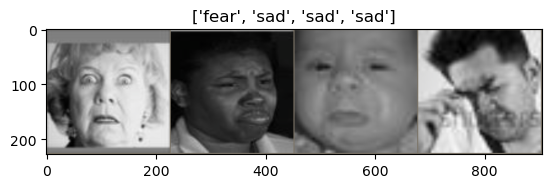

In [2]:
import torchvision


def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(DataLoader(train_dataset, batch_size=4, shuffle=True)))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[emotions[x] for x in classes])


In [3]:
from torch.optim.lr_scheduler import ReduceLROnPlateau


# Define the ResNet50 model with custom final layer
class ResNet50EmotionModel(nn.Module):
    def __init__(self, num_classes):
        super(ResNet50EmotionModel, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.fc = nn.Sequential(
            #nn.Dropout(0.7), 
            nn.Linear(self.resnet.fc.in_features, num_classes)
        )

    def forward(self, x):
        x = self.resnet(x)
        return x

model = ResNet50EmotionModel(num_classes=num_classes).to(device)

# Define optimizer and learning rate scheduler
criterion = nn.CrossEntropyLoss()
#todo try increasing weight decay?
optimizer = AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Training loop
num_epochs = 40  # Number of epochs
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)

    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in (train_dl if phase == 'train' else val_dl):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data).item()

        epoch_loss = running_loss / len(train_dataset if phase == 'train' else val_dataset)
        epoch_acc = running_corrects / len(train_dataset if phase == 'train' else val_dataset)

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        if phase == 'train':
            train_losses.append(epoch_loss)
        else:
            val_losses.append(epoch_loss)
            scheduler.step(epoch_loss)

    current_lr = optimizer.param_groups[0]['lr']
    print(f'Current learning rate: {current_lr:.6f}')

print('Training complete')

torch.save(model.state_dict(), 'resnet50_emotion_model.pth')


C:\Users\Jannik\anaconda3\envs\python3.9\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Jannik\anaconda3\envs\python3.9\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/39
----------
train Loss: 0.9090 Acc: 0.6479
val Loss: 0.7215 Acc: 0.7442
Current learning rate: 0.000100
Epoch 1/39
----------
train Loss: 0.5993 Acc: 0.7805
val Loss: 0.5499 Acc: 0.7794
Current learning rate: 0.000100
Epoch 2/39
----------
train Loss: 0.4627 Acc: 0.8342
val Loss: 0.5394 Acc: 0.8002
Current learning rate: 0.000100
Epoch 3/39
----------
train Loss: 0.3525 Acc: 0.8732
val Loss: 0.5848 Acc: 0.7947
Current learning rate: 0.000100
Epoch 4/39
----------
train Loss: 0.2939 Acc: 0.8954
val Loss: 0.5961 Acc: 0.7936
Current learning rate: 0.000100
Epoch 5/39
----------
train Loss: 0.2265 Acc: 0.9181
val Loss: 0.6410 Acc: 0.8123
Current learning rate: 0.000100
Epoch 6/39
----------
train Loss: 0.1736 Acc: 0.9402
val Loss: 0.5834 Acc: 0.8178
Current learning rate: 0.000050
Epoch 7/39
----------
train Loss: 0.0881 Acc: 0.9723
val Loss: 0.5311 Acc: 0.8441
Current learning rate: 0.000050
Epoch 8/39
----------
train Loss: 0.0491 Acc: 0.9848
val Loss: 0.5819 Acc: 0.8222
Curren

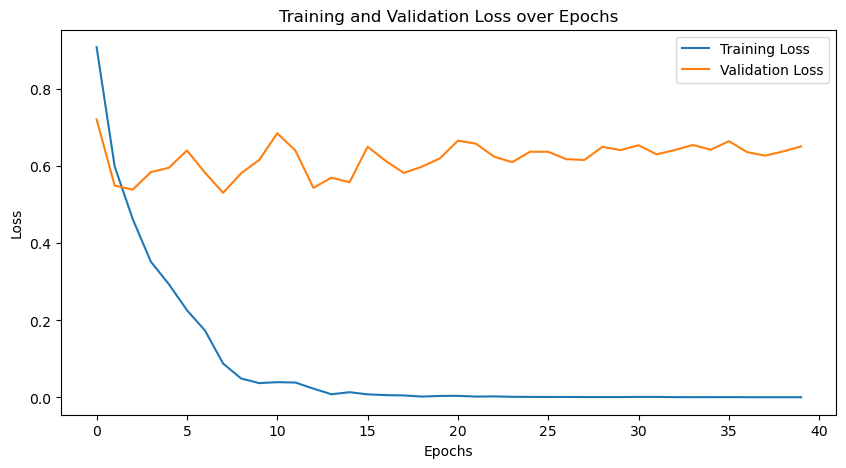

In [4]:
# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [5]:
# Test the model
test_dir = 'data/test'
test_files = [os.path.join(test_dir, img_file) for img_file in os.listdir(test_dir)]
test_dataset = EmotionDataset(test_files, transform=transform_val)
test_dl = DataLoader(test_dataset, batch_size=16, shuffle=False)

model.eval()
results = []

for inputs in test_dl:
    inputs = inputs.to(device)
    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        preds = preds.cpu().numpy()
        results.extend(preds)

results_df = pd.DataFrame({'Id': [os.path.basename(file) for file in test_files], 'emotions': [emotions[pred] for pred in results]})
results_df.to_csv('predictions_resnet50.csv', index=False)


restnet50 model with 40 epochs and 0.0001 learning rate
Epoch 37/39
----------
train Loss: 0.0010 Acc: 1.0000
val Loss: 0.6706 Acc: 0.8405
Current learning rate: 0.000000
Epoch 38/39
----------
train Loss: 0.0008 Acc: 1.0000
val Loss: 0.6659 Acc: 0.8522
Current learning rate: 0.000000
Epoch 39/39
----------
train Loss: 0.0009 Acc: 0.9999
val Loss: 0.6657 Acc: 0.8449
Current learning rate: 0.000000
Training complete

- adjust val set to 10% of the data, adjust batch size to 16, 25 epochs -> BEST MODEL YET (84,3% Kaggle score)
train Loss: 0.0026 Acc: 0.9994
val Loss: 0.6653 Acc: 0.8518
Current learning rate: 0.000003
Epoch 24/39
----------
train Loss: 0.0011 Acc: 1.0000
val Loss: 0.6839 Acc: 0.8474
Current learning rate: 0.000003
Epoch 25/39
----------
train Loss: 0.0013 Acc: 0.9998
val Loss: 0.6637 Acc: 0.8507
Current learning rate: 0.000003